In [1]:
import keras
import os
import joblib
import numpy as np
import tensorflow as tf
import support_functions as sf
import matplotlib.pyplot as plt
import keras.layers as layers
import sklearn.model_selection as model_selection

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [2]:
# GPU
# sf.limit_gpu_memory(6000)
sf.gpu_check()

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

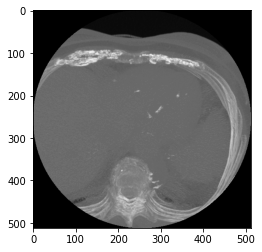

In [3]:
# Read slices
SLICES_JOBLIB_PATH = os.path.join('scans','scans_max_normalised_float32.joblib')

slice = joblib.load(SLICES_JOBLIB_PATH)[0]

sf.display_dicom_slice(slice)

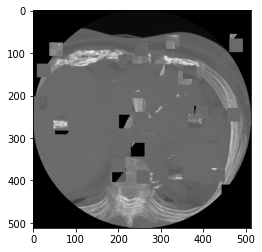

In [4]:
# Corrupt scans
NUMBER_OF_SWITCHES = 15
PATCH_SIZE = 32

corrupted_slice = np.array(sf.corrupt_image(slice, NUMBER_OF_SWITCHES, PATCH_SIZE))
sf.display_dicom_slice(corrupted_slice)

In [5]:
corrupted_slice = np.resize(corrupted_slice, (1, corrupted_slice.shape[0], corrupted_slice.shape[1], 1))
corrupted_slice.shape

(1, 512, 512, 1)

In [6]:
# Use mulitple GPU's
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [7]:
with strategy.scope():
    analyzer = keras.models.load_model('./models/winnovation_model/analyzer.h5')

In [8]:
with strategy.scope():
    layer_outputs = [layer.output for layer in analyzer.layers] # Extracts the outputs of the top 12 layers
    activation_model = keras.models.Model(inputs=analyzer.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [9]:
activation_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 128)     1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 128)     147584    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 128)     147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 256)     295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 256)     590080

In [10]:
with strategy.scope():
    activations = activation_model.predict(corrupted_slice) # Returns a list of five Numpy arrays: one array per layer activation

In [11]:
activations[0].shape

(1, 512, 512, 128)

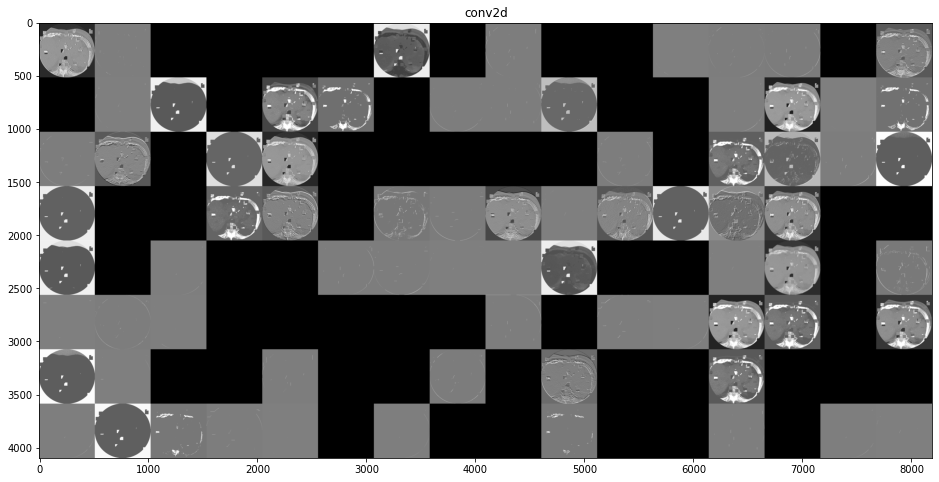

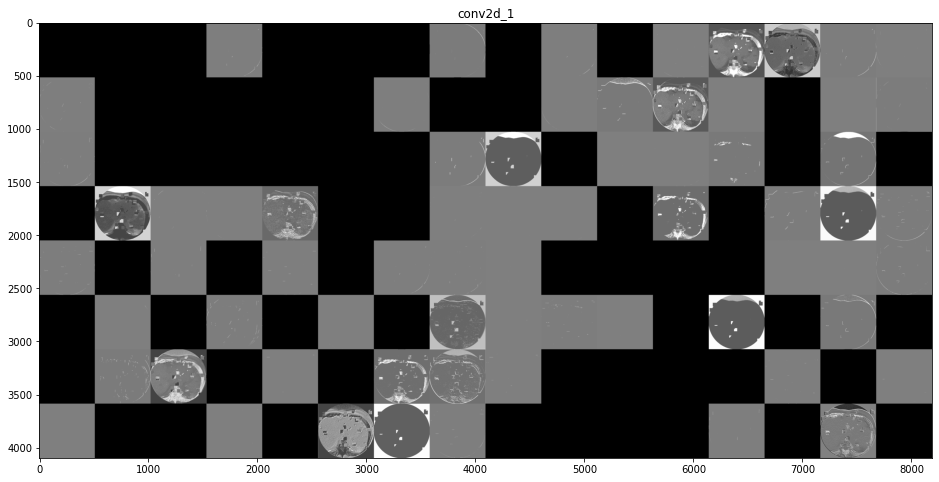

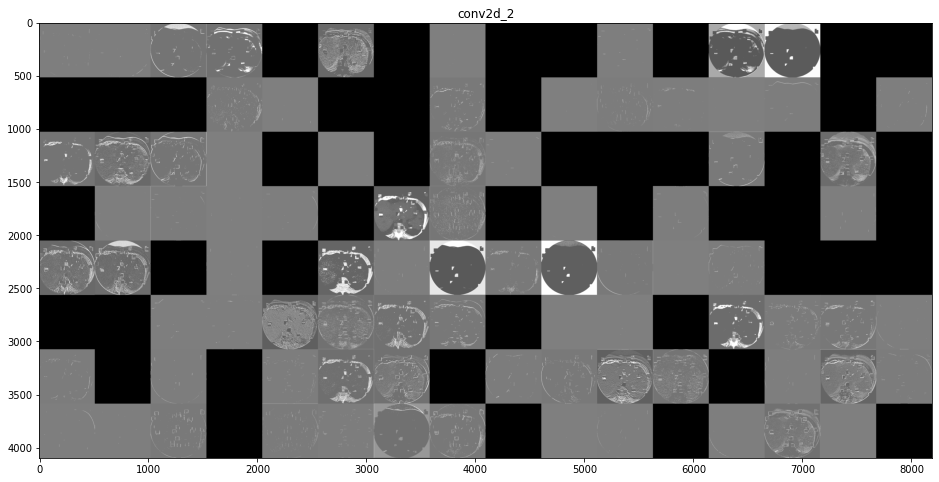

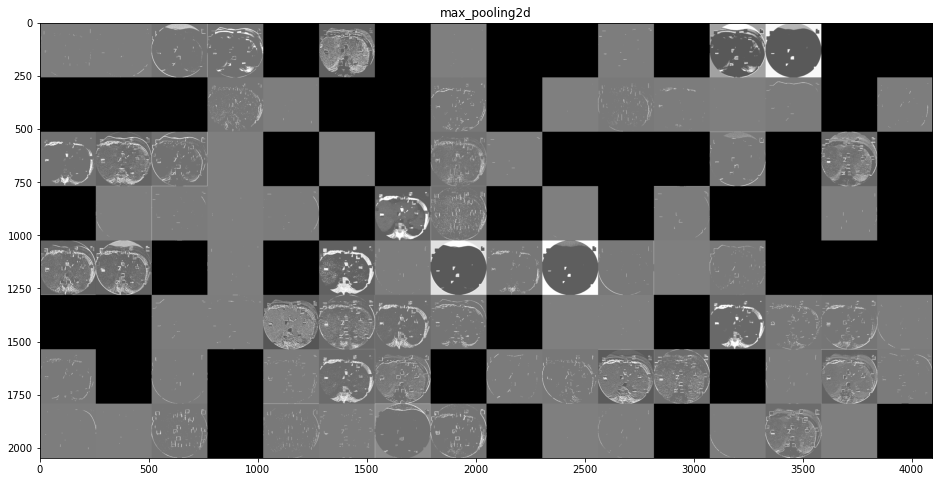

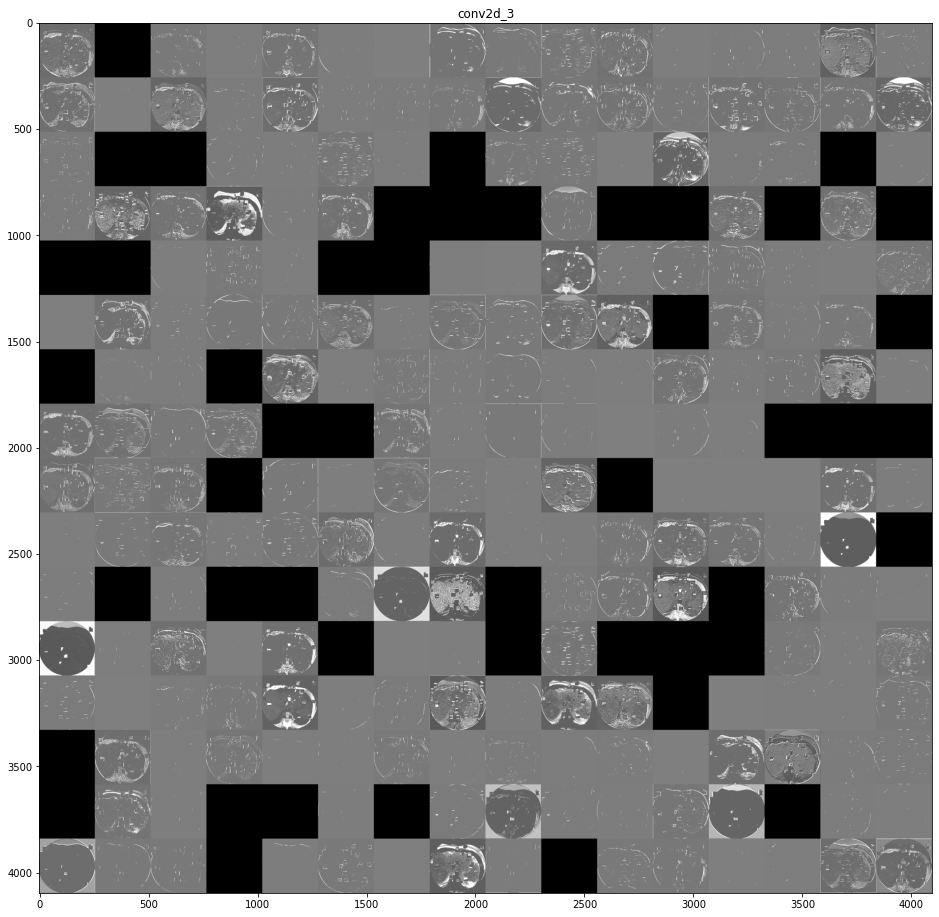

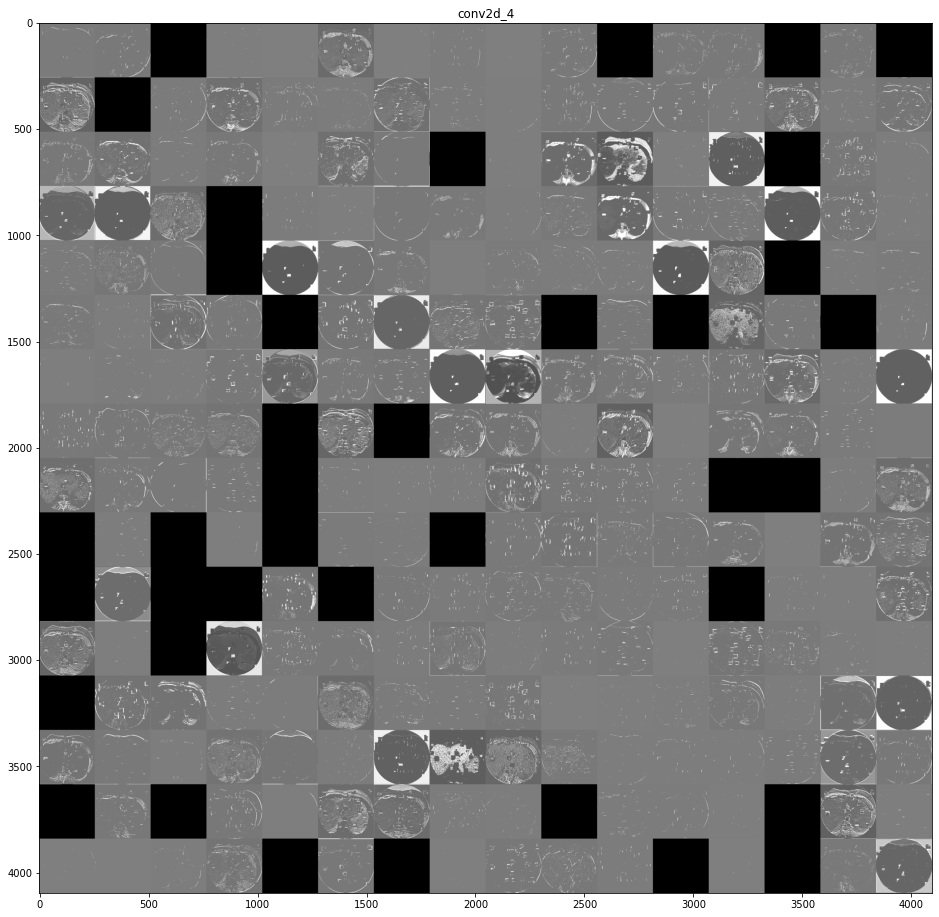

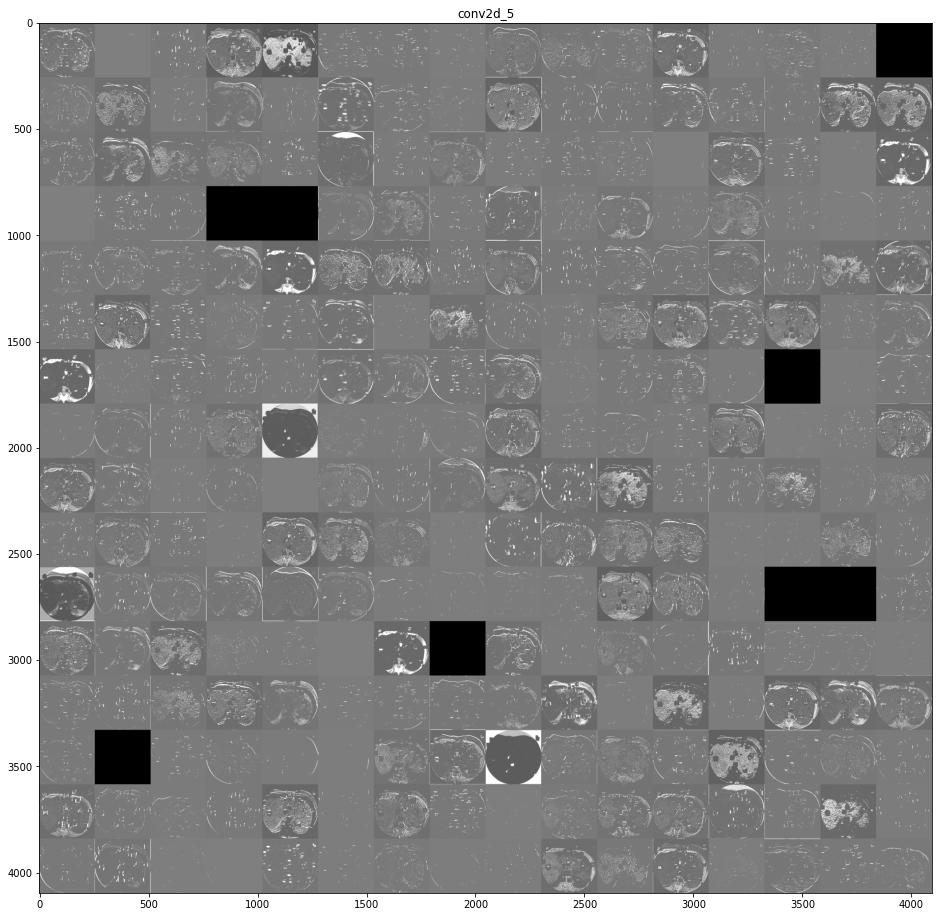

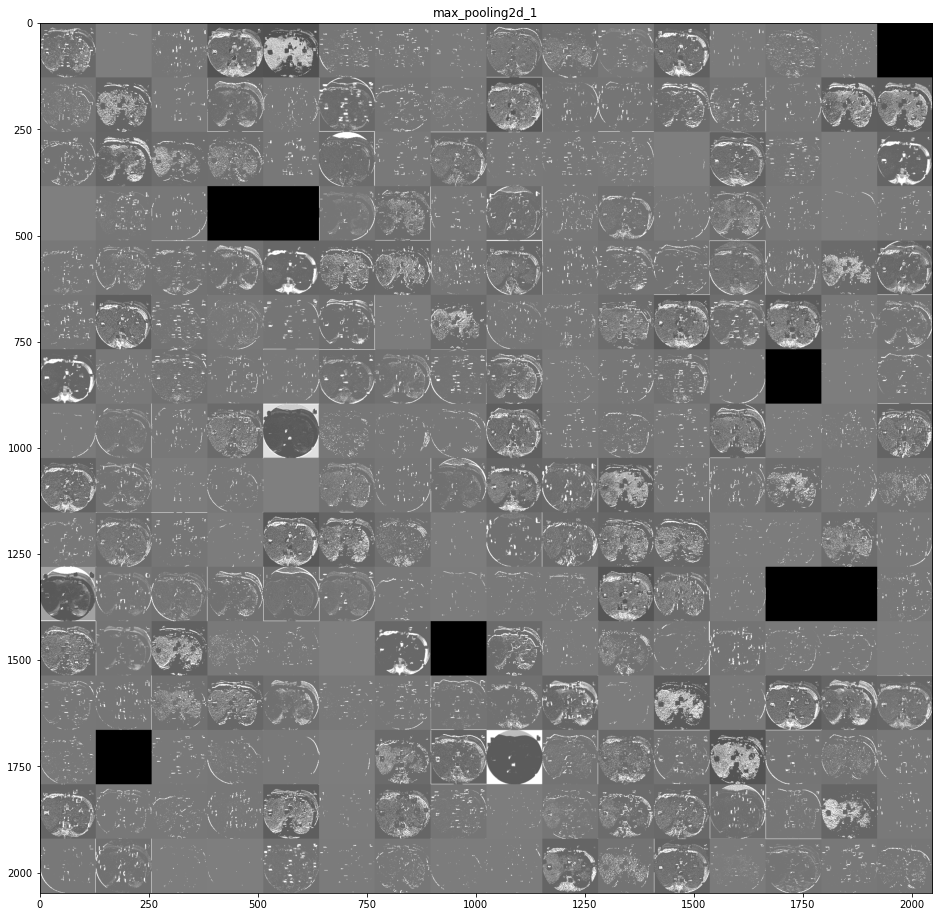

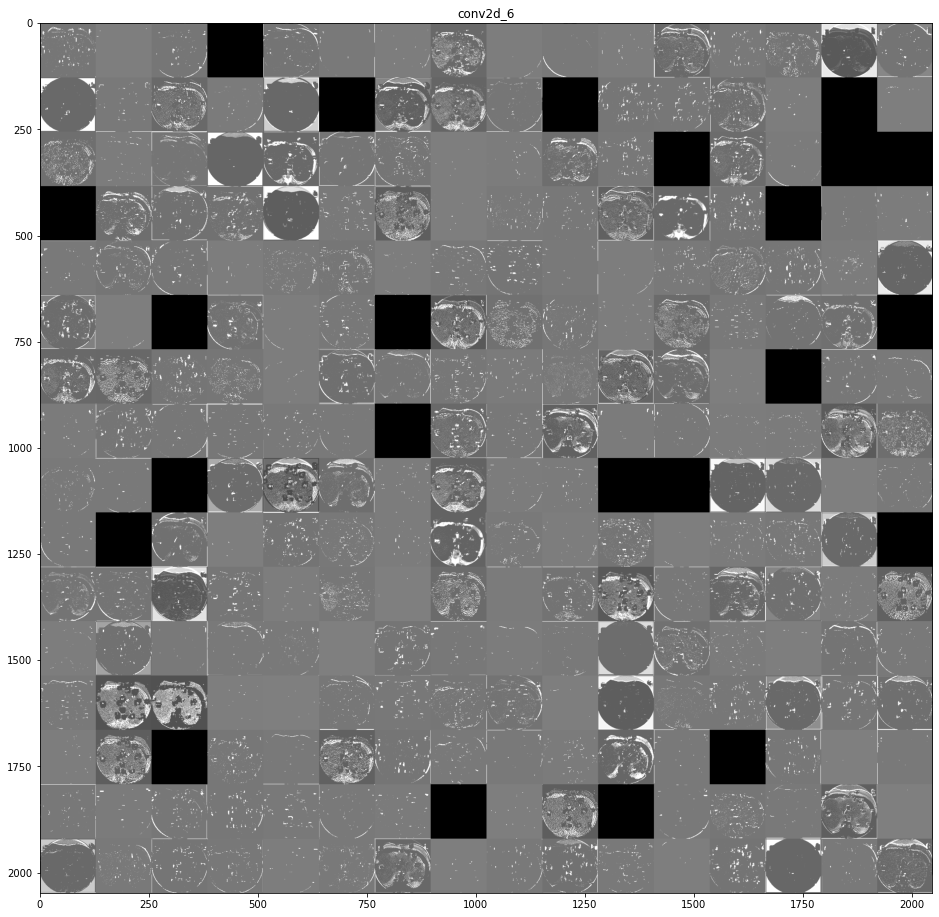

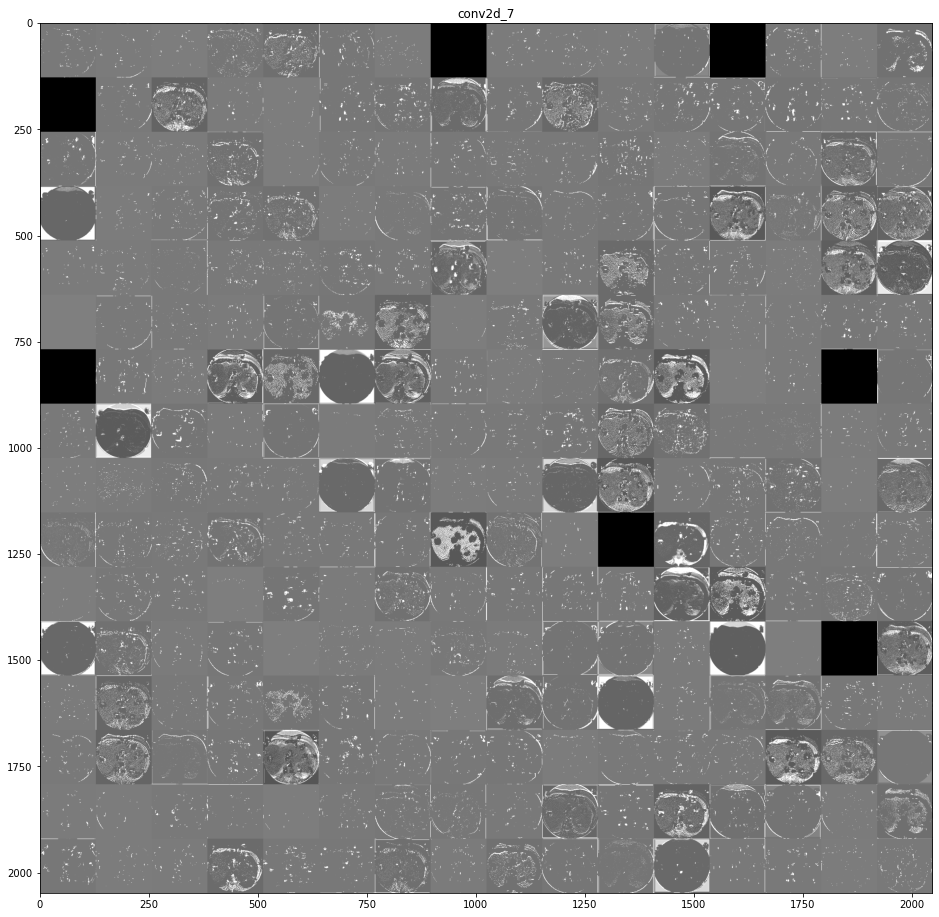

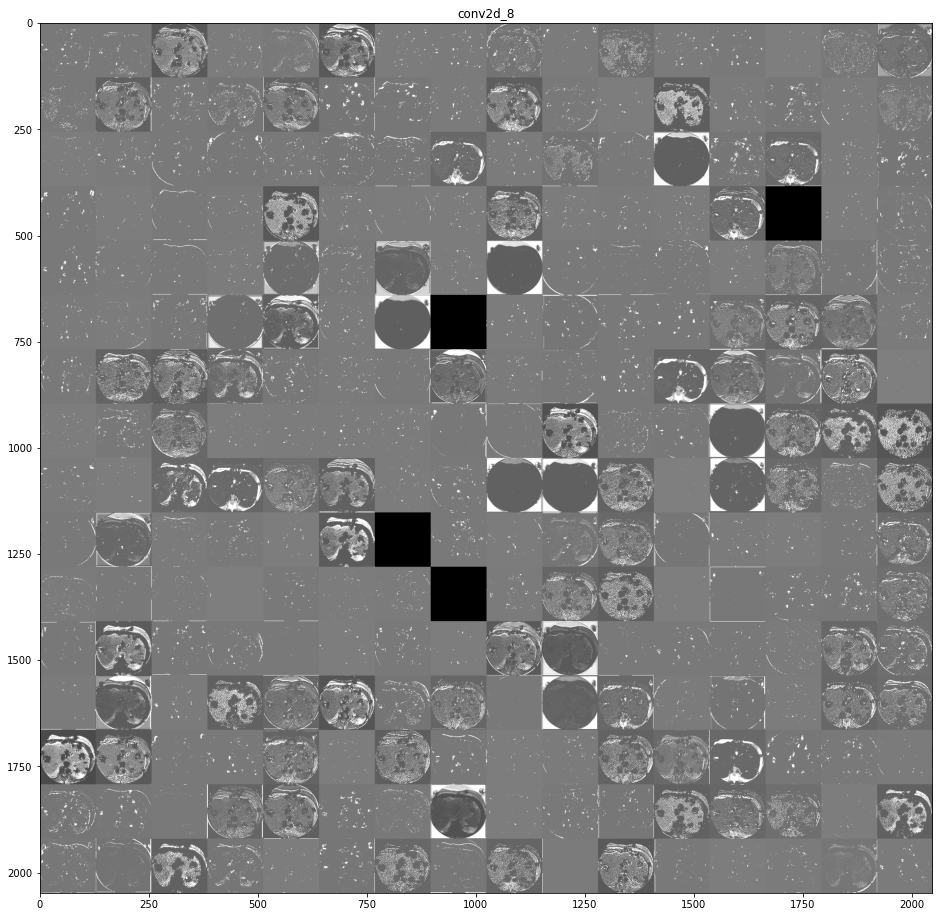

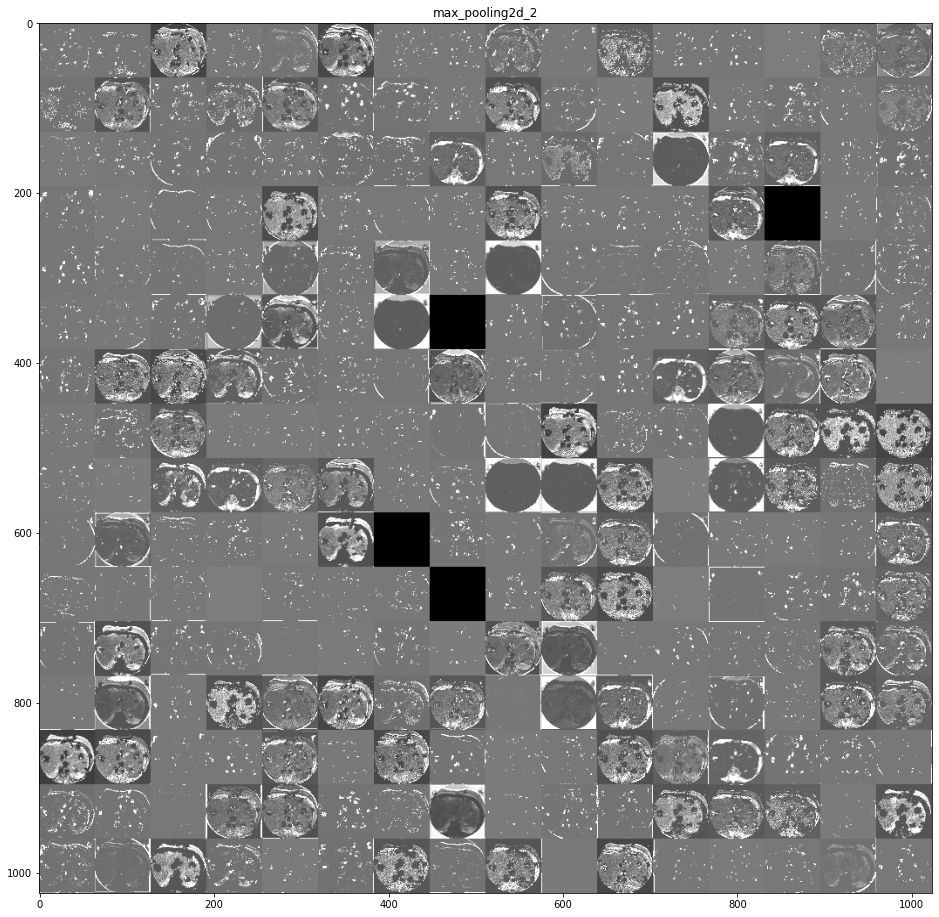

In [15]:
layer_names = []
for layer in analyzer.layers:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap=plt.cm.gray)

In [ ]:
activations.shape